# MSHA Fatality Report Data Extraction

This code looks at all of the MSHA fatality reports from 2010 to 2024 and analyzes trends in fatalaties.  

## Install necessary packages

The selenium package (alongside the webdriver-manager package) is used to download all of the required MSHA fatality reports from the MSHA online database.

In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pylab as plt



import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

# Download MSHA Fatality Reports

The following code downloads the fatality report located in the MSHA online database URL. The URL's are changed manually for each year's page and then the code is ran to download each year's fatality report. 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import requests
import os
import time

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# MSHA online database URL used for downloading fatality reports for a specific page
# *** The URL was changed every time associated to each page for each fatalatiy report. The URL below is for Page 1 *** 
url = "https://www.msha.gov/data-and-reports/fatality-reports/search?combine=&field_mine_category_target_id=186&year=all&location_node_administrative_area=All&page=0"
driver.get(url)

# Create directory for fatality report PDFs
os.makedirs('pdfs', exist_ok=True)

# Loop through all pages for each fatality report
while True:
    # find all buttons on the page
    report_links = driver.find_elements(By.PARTIAL_LINK_TEXT, "Preliminary Report for")
    
    
    for i in range(len(report_links)):
        report_links = driver.find_elements(By.PARTIAL_LINK_TEXT, "Preliminary Report for")
        
        report_links[i].click()
        time.sleep(2)  
        
        # downloading the pdf
        try:
            pdf_url = driver.find_element(By.XPATH, "//a[contains(@href, '.pdf')]").get_attribute("href")
            pdf_name = pdf_url.split("/")[-1]
            pdf_response = requests.get(pdf_url)
            with open(f'pdfs/{pdf_name}', 'wb') as file:
                file.write(pdf_response.content)
            print(f"Downloaded {pdf_name}")
        except Exception as e:
            print(f"Error downloading PDF: {e}")
        
        driver.back()
        time.sleep(2)  
    
    # *** The following the code is supposed to find the next page number to move to the next page for the fatality report, 
    #     however this did not work and manually changed the URL to each page ***

    # try:
    #     # Locate the current page number and the next page number
    #     current_page = driver.find_element(By.CSS_SELECTOR, ".pager__item--active")
    #     next_page = current_page.find_element(By.XPATH, "following-sibling::li/a")
        
    #     next_page.click()
    #     time.sleep(2)  
    # except:
    #     print("No more pages to process.")
    #     break  # Exit the loop if there's no "next page" available

driver.quit()


No more pages to process.


## Convert Fatality Report PDF's to images

The tesserect package converts the downloaded fatality report PDF's to an image for data extraction.

In [6]:
pip install pytesseract pdf2image Pillow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from pdf2image import convert_from_path
import pytesseract
import re
import pandas as pd

# Set the Tesseract path
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'  

# Path to the folder containing PDFs
pdf_folder = "/Users/komalmann/Desktop/pdfs"
poppler_path = '/opt/homebrew/bin' 

# List to store data for each PDF
data = []

# Loop through each PDF file in the folder
for pdf_filename in os.listdir(pdf_folder):
    if pdf_filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder, pdf_filename)
        
        # Convert PDF to images using Poppler
        images = convert_from_path(pdf_path, dpi=300, poppler_path=poppler_path)

        # Process all pages in the PDF
        text = ""
        for i, image in enumerate(images):
            page_text = pytesseract.image_to_string(image)
            text += f"--- Page {i+1} ---\n{page_text}\n"
        

        # Extract Accident Classification
        accident_classification_match = re.search(
            r'2\. Accident Classification\s*.*?\n\s*(.*?)(?:\n|$)', text, re.S
        )
        accident_classification = (
            accident_classification_match.group(1).strip() if accident_classification_match else "Not found"
        )
        
        # Remove any date/time references from the classification text (e.g., "12/14/2023", "7:34 AM")
        accident_classification_cleaned = re.sub(r'\d{2}/\d{2}/\d{4}.*?(\d{1,2}:\d{2}\s*(AM|PM))', '', accident_classification)

        # Extract Date/Time of Accident
        date_time_match = re.search(
            r'3\. Date/Time of Accident\s*.*?(\d{2}/\d{2}/\d{4}\s+\d{1,2}:\d{2}\s*(AM|PM))', text, re.S
        )
        date_time_of_accident = date_time_match.group(1).strip() if date_time_match else "Not found"
        
        # Extract the state using the predefined list of state abbreviations
        state_found = "Not found"
        state_abbreviations = [
            'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 
             'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 
            'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
        ]
        for state in state_abbreviations:
            state_match = re.search(r'\b' + state + r'\b', text)
            if state_match:
                state_found = state_match.group(0)
                break
        
        if state_found == "Not found":
            state_match = re.search(r'\bState\s*[:\-]?\s*([A-Z]{2})\b', text, re.S)
            if state_match:
                state_found = state_match.group(1)
        
        # Extract Primary Mineral Mined
        mineral_match = re.search(r'10\. Primary Mineral Mined.*?\n\s*(.*?)(?:\n|$)', text, re.S)
        primary_mineral = mineral_match.group(1).strip() if mineral_match else "Not found"
        
        # Append extracted information to the data list
        data.append({
            "PDF Filename": pdf_filename,
            "Accident Classification": accident_classification_cleaned,  # Use cleaned classification
            "Date/Time of Accident": date_time_of_accident,
            "State": state_found,
            "Primary Mineral Mined": primary_mineral
        })

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

print(df)

# Save the DataFrame to a CSV file
output_path = "/Users/komalmann/Desktop/extracted_data.csv"
df.to_csv(output_path, index=False)


print(f"\nData saved to {output_path}")

# Analyze how many "Not found" entries
not_found_counts = (df == "Not found").sum()
total_not_found = not_found_counts.sum()
print("\nCount of 'Not found' entries per column:")
print(not_found_counts)
print(f"Total 'Not found' entries: {total_not_found}")


                                          PDF Filename  \
0      March%204%202022%20-%20Preliminary%20Report.pdf   
1                                  2012MNM02prelim.pdf   
2                                  2013MNM09prelim.pdf   
3    November%2013%2C%202023%20-%20Preliminary%20Re...   
4                                  2014MNM04prelim.pdf   
..                                                 ...   
281  January%204%2C%202023%20-%20Preliminary%20Repo...   
282  October%207%202022%20-%20Preliminary%20Report%...   
283  August%2022%202024%20-%20Preliminary%20Report-...   
284   May%202%2C%202023%20-%20Preliminary%20Report.pdf   
285  December%2014%202023-Preliminary%20Report%20Bi...   

                               Accident Classification Date/Time of Accident  \
0                             3. Date/Time of Accident   03/04/2022 10:58 AM   
1    Fatal Injury Fall of Face, Rib, Pillar or High...   02/14/2012 04:30 PM   
2                                                         06/13

## Data exploration with the Dataframe of Fatalties

### Cleaning up the Fatalities dataframe.

In [562]:
# Split the "Date/Time of Accident" into separate "Date" and "Time" columns
df[['Date', 'Time']] = df['Date/Time of Accident'].str.split(' ', n=1, expand=True)

print(df)


                                          PDF Filename  \
0      March%204%202022%20-%20Preliminary%20Report.pdf   
1                                  2012MNM02prelim.pdf   
2                                  2013MNM09prelim.pdf   
3    November%2013%2C%202023%20-%20Preliminary%20Re...   
4                                  2014MNM04prelim.pdf   
..                                                 ...   
283  August%2022%202024%20-%20Preliminary%20Report-...   
284   May%202%2C%202023%20-%20Preliminary%20Report.pdf   
285  December%2014%202023-Preliminary%20Report%20Bi...   
286  December%2014%202023-Preliminary%20Report%20Bi...   
287  December%2014%202023-Preliminary%20Report%20Bi...   

                               Accident Classification Date/Time of Accident  \
0                             3. Date/Time of Accident   03/04/2022 10:58 AM   
1    Fatal Injury Fall of Face, Rib, Pillar or High...   02/14/2012 04:30 PM   
2                                                         06/13

In [564]:
# Append extracted information to the data list
data.append({
    "PDF Filename": pdf_filename,
    "Accident Classification": accident_classification,
    "Date/Time of Accident": date_time_of_accident,
    "State": state_found,
    "Primary Mineral Mined": primary_mineral
})

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

# Split the "Date/Time of Accident" into separate "Date" and "Time" columns
df[['Date', 'Time']] = df['Date/Time of Accident'].str.split(' ', n=1, expand=True)

# Display the updated DataFrame
print(df)

# Save the DataFrame to a CSV file
output_path = "/Users/komalmann/Desktop/extracted_data.csv"
df.to_csv(output_path, index=False)

print(f"\nData saved to {output_path}")


                                          PDF Filename  \
0      March%204%202022%20-%20Preliminary%20Report.pdf   
1                                  2012MNM02prelim.pdf   
2                                  2013MNM09prelim.pdf   
3    November%2013%2C%202023%20-%20Preliminary%20Re...   
4                                  2014MNM04prelim.pdf   
..                                                 ...   
284   May%202%2C%202023%20-%20Preliminary%20Report.pdf   
285  December%2014%202023-Preliminary%20Report%20Bi...   
286  December%2014%202023-Preliminary%20Report%20Bi...   
287  December%2014%202023-Preliminary%20Report%20Bi...   
288  December%2014%202023-Preliminary%20Report%20Bi...   

                               Accident Classification Date/Time of Accident  \
0                             3. Date/Time of Accident   03/04/2022 10:58 AM   
1    Fatal Injury Fall of Face, Rib, Pillar or High...   02/14/2012 04:30 PM   
2                                                         06/13

## Accident Classification Analysis

Determining what type of accident types result in the most amount of fatalaties

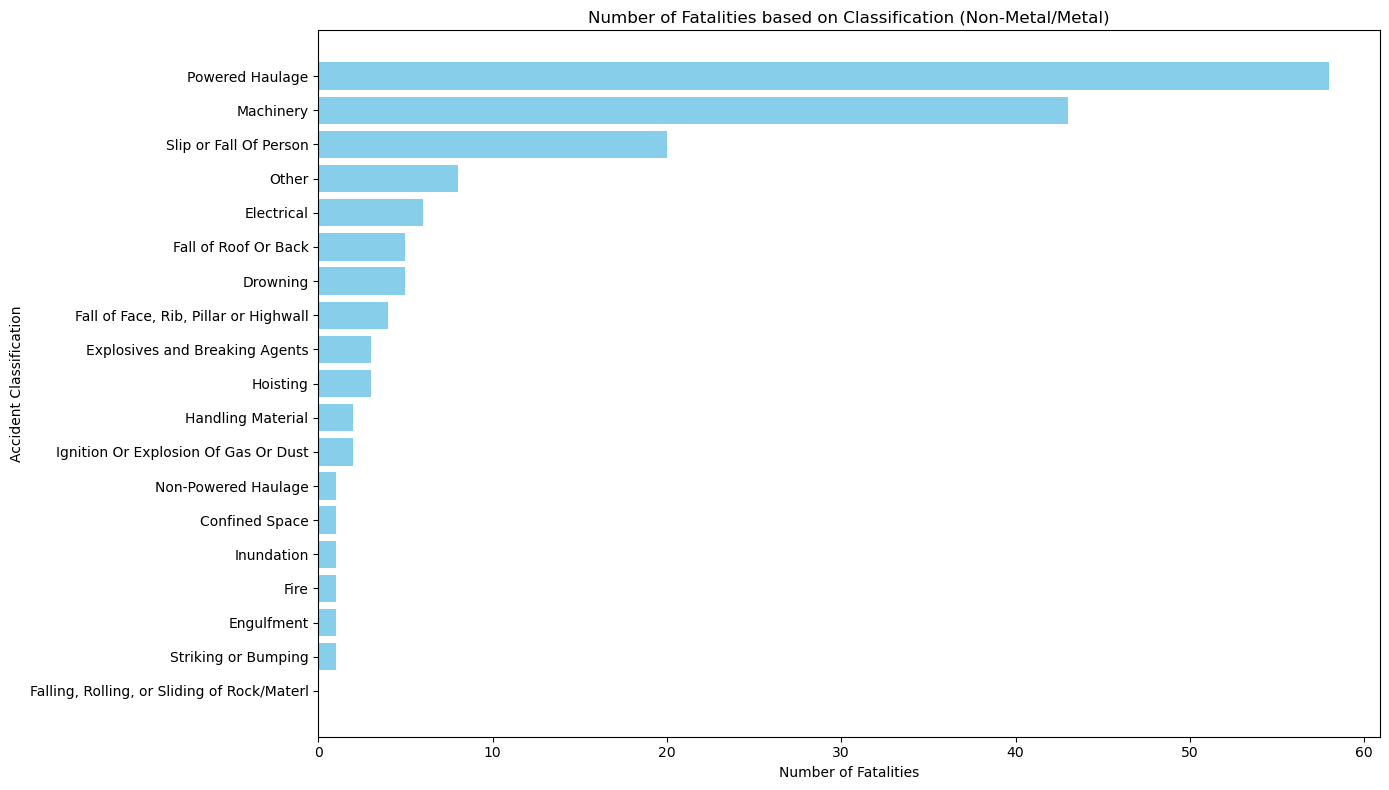

In [ ]:
# List of accident type keywords 
keywords = [
    "Confined Space", "Drowning", "Electrical", "Engulfment", 
    "Explosives and Breaking Agents", 
    "Fall of Face, Rib, Pillar or Highwall", "Fall of Roof Or Back", 
    "Falling, Rolling, or Sliding of Rock/Materl", "Fire", 
    "Handling Material", "Hoisting", 
    "Ignition Or Explosion Of Gas Or Dust","Inundation", 
    "Machinery", "Non-Powered Haulage", "Other", "Powered Haulage", 
    "Slip or Fall Of Person", 
    "Striking or Bumping"
]

# Create a dictionary to count occurrences
keyword_counts = {keyword: 0 for keyword in keywords}

# Count the occurrences of each keyword
for keyword in keywords:
    keyword_counts[keyword] = df['Accident Classification'].str.contains(keyword, case=False, na=False).sum()

# Convert to a DataFrame
keyword_df = pd.DataFrame(list(keyword_counts.items()), columns=['Keyword', 'Count'])

# Sort by count
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

# Plot the data
plt.figure(figsize=(14, 8))
plt.barh(keyword_df['Keyword'], keyword_df['Count'], color='skyblue')
plt.title('Number of Fatalities based on Classification (Non-Metal/Metal)')
plt.xlabel('Number of Fatalities')
plt.ylabel('Accident Classification')
plt.tight_layout()
plt.gca().invert_yaxis() 
plt.show()


## Fatality over Time Analysis

Visualizing the number of fatalities occuring between 2010-2024

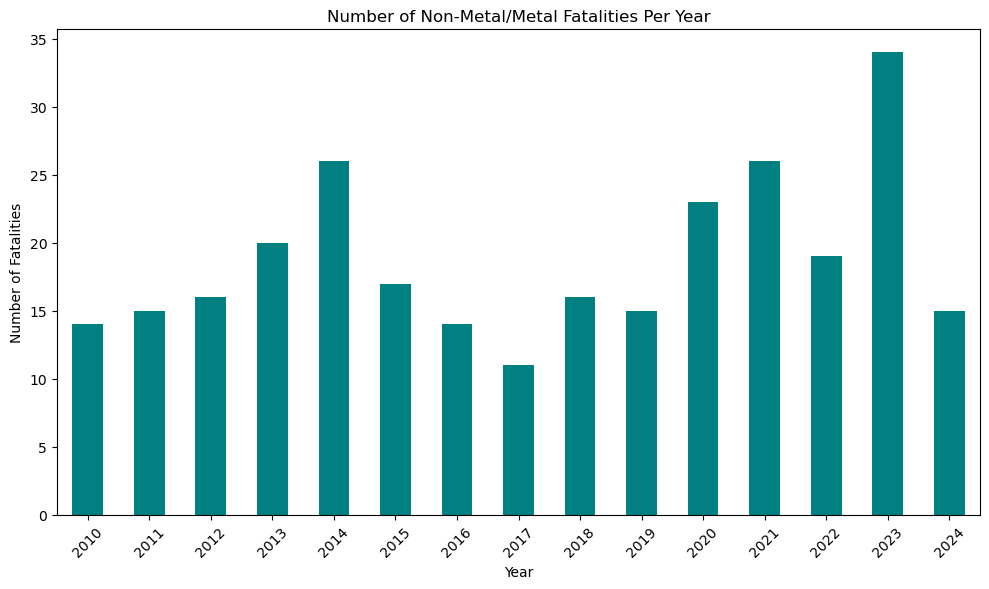

In [680]:

# Ensure the `Date` column is in datetime format and remove invalid dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Extract the year from the `Date` column
df['Year'] = df['Date'].dt.year

# Group by year and count the number of accidents
accidents_per_year = df['Year'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
accidents_per_year.plot(kind='bar', color='teal')
plt.title('Number of Non-Metal/Metal Fatalities Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fatalities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Based on the accident classification analysis, Powered Haulage and Machinery result in the most fatalities. 

Therefore, the following graph will explore the distribution of the fatalties resulting from these accident types over time in depth. 

### Powered Haulage and Machinery Fatality Analysis

<Figure size 1000x600 with 0 Axes>

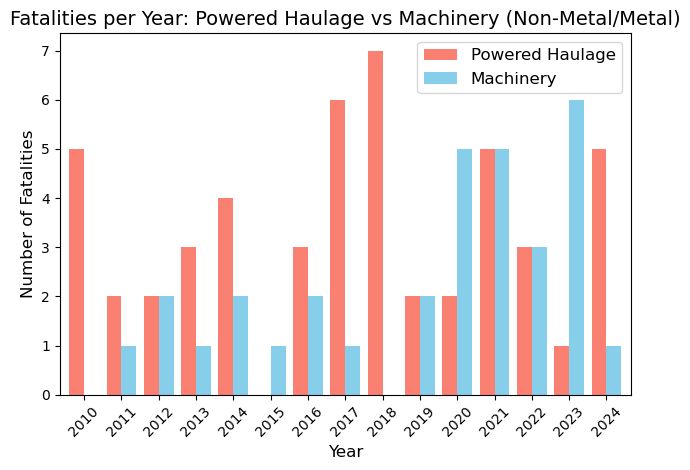

In [686]:

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter for Powered Haulage accidents
powered_haulage_df = df[df['Accident Classification'].str.contains('Powered Haulage', na=False)]
fatalities_powered_haulage = powered_haulage_df[powered_haulage_df['Accident Classification'].str.contains('Fatal', na=False)]
fatalities_powered_haulage['Year'] = fatalities_powered_haulage['Date'].dt.year

# Filter for Machinery accidents
machinery_df = df[df['Accident Classification'].str.contains('Machinery', na=False)]
fatalities_machinery = machinery_df[machinery_df['Accident Classification'].str.contains('Fatal', na=False)]
fatalities_machinery['Year'] = fatalities_machinery['Date'].dt.year

# Group by Year and count fatalities
powered_haulage_counts = fatalities_powered_haulage.groupby('Year').size()
machinery_counts = fatalities_machinery.groupby('Year').size()

# Combine data into a single DataFrame
combined_data = pd.DataFrame({
    'Powered Haulage': powered_haulage_counts,
    'Machinery': machinery_counts
}).fillna(0)  # Fill missing values with 0

# Plot the data
plt.figure(figsize=(10, 6))
combined_data.plot(kind='bar', width=0.8, color=['salmon', 'skyblue'])
plt.title('Fatalities per Year: Powered Haulage vs Machinery (Non-Metal/Metal)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Fatalities', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(['Powered Haulage', 'Machinery'], fontsize=12)
plt.tight_layout()
plt.show()


## Seasonal analysis exploration

The following graphs explores whether seasons and fatalities had a correlation.

In [ ]:
#function to determine the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# Ensure the `Date` column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Remove invalid dates
df = df.dropna(subset=['Date'])

# Extract the month and apply the season function
df['Month'] = df['Date'].dt.month
df['Season'] = df['Month'].apply(get_season)

print(df[['Date', 'Month', 'Season']].head())



        Date  Month  Season
0 2022-03-04      3  Spring
1 2012-02-14      2  Winter
2 2013-06-13      6  Summer
3 2023-11-13     11  Autumn
4 2014-03-27      3  Spring


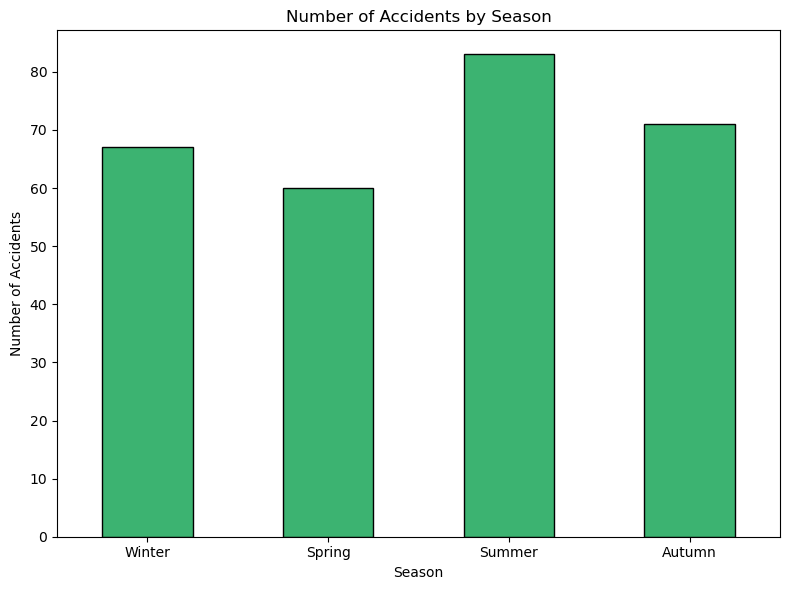

In [ ]:

# Group by `Season` and count the number of accidents
accidents_by_season = df['Season'].value_counts()

# Sort seasons
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
accidents_by_season = accidents_by_season.reindex(season_order)

# Plot the data
plt.figure(figsize=(8, 6))
accidents_by_season.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Number of Fatalities by Season')
plt.xlabel('Season')
plt.ylabel('Number of Fatalities')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()


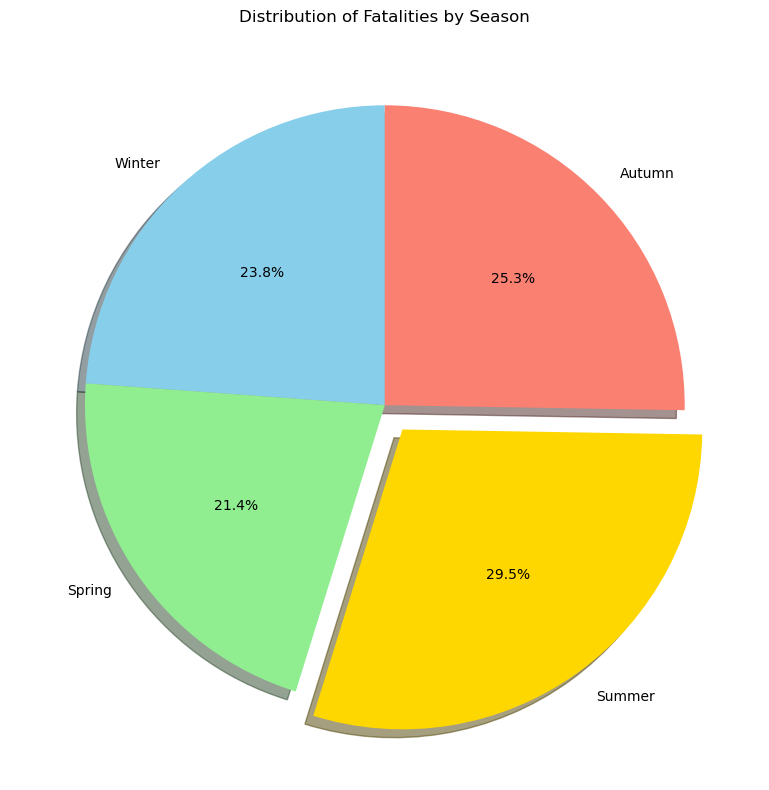

In [630]:

# Group by `Season` and count the number of accidents
accidents_by_season = df['Season'].value_counts()

# Sort seasons in the desired order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
accidents_by_season = accidents_by_season.reindex(season_order)

# Plot the data as a pie chart, emphasizing Summer
plt.figure(figsize=(8, 8))
accidents_by_season.plot(
    kind='pie',
    autopct='%1.1f%%',  
    colors=['skyblue', 'lightgreen', 'gold', 'salmon'],
    startangle=90,  
    explode=(0, 0, 0.1, 0),  
    shadow=True
)
plt.title('Distribution of Fatalities by Season')
plt.ylabel('')  
plt.tight_layout()
plt.show()



The above data exploration for seasonal analysis did not show any conclusive correlation for fatalaties as there is a relatively even distribution across all the seasons. Therefore, this is disregarded in the final analysis. 

## State-wise Fatality Analysis

The following data exploration looks at the fatalies occurred by US State.

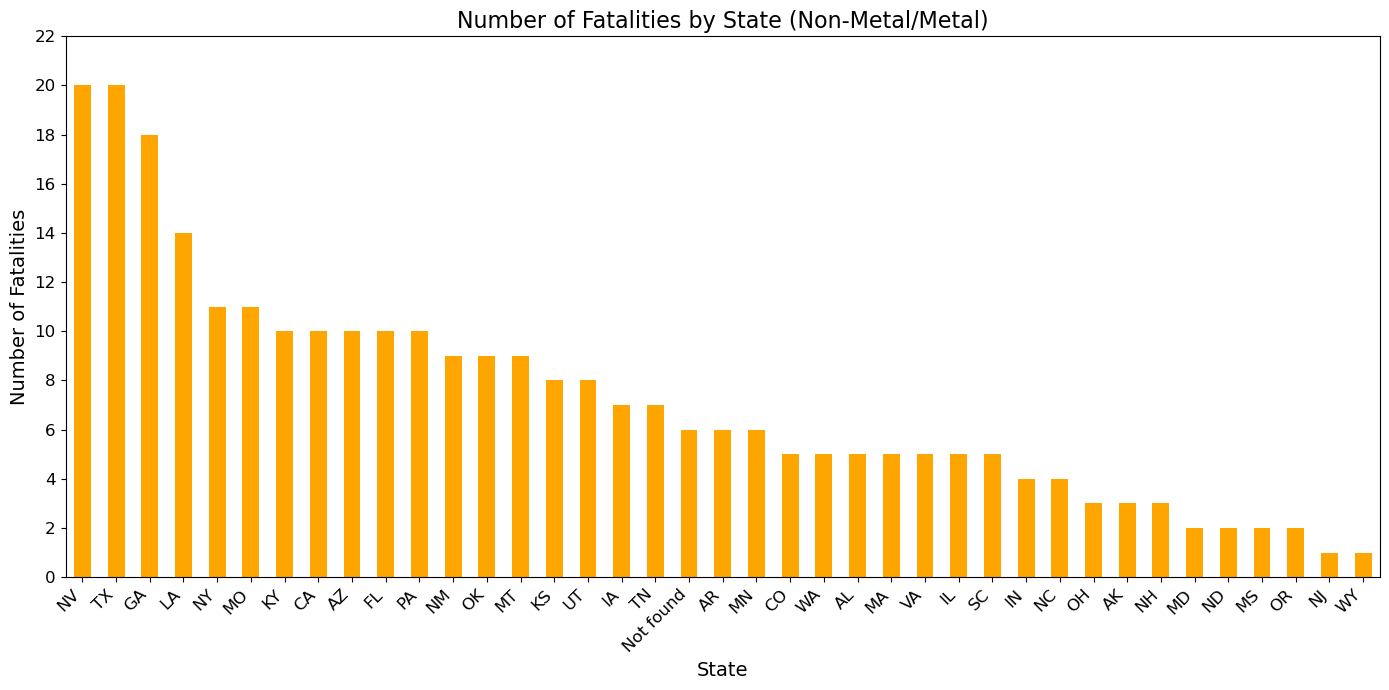

In [ ]:

# Group by `State` and count the number of accidents
accidents_by_state = df['State'].value_counts()

# Sort states by the number of accidents (descending order)
accidents_by_state = accidents_by_state.sort_values(ascending=False)

# Plot the data as a bar chart
plt.figure(figsize=(14, 7))
accidents_by_state.plot(kind='bar', color='orange')
plt.title('Number of Fatalities by State (Non-Metal/Metal)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Fatalities', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.yticks(fontsize=12)

plt.ylim(0, 22)
plt.yticks(range(0, 23, 2))
plt.tight_layout()
plt.show()


Nevada and Texas are the states with the most fatalaties. This makes sense as these states have a high number of mines. 